# Beam scan plotting and fitting script (Data measured from WinCamD)

### This script makes some assumptions about a few things:
 - Assumes some well established reference point from which you are measuring
 - Assumes the distance incrementation along z is in inches
 - Assumes you want to know about waist size and waist position

In [1]:
import pandas as pd
import scipy.optimize as sciopt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

import data

In [2]:
fname = '01_12_2021'
folder = '../../../measurements/beam_scans/'
data = pd.read_excel(folder + fname+'.xlsx')
data_np = np.array(data)

In [3]:
data_np

array([['z (inches)', 'x diameter (\\mu m)', 'y diamter (\\mu m)'],
       [8, 712, 986.5],
       [9, 663.2, 832.9],
       [10, 579.8, 721.3],
       [17, 450.7, 240.8],
       [18, 476.3, 261.9],
       [19, 485.3, 316.6],
       [20, 485.4, 377.2],
       [21, 499.1, 505.1]], dtype=object)

organize data

In [4]:
z = data_np[1:,0]
z_met = z*.0254
rad_x = data_np[1:,1]*.5e-6
rad_y = data_np[1:,2]*.5e-6

In [5]:
## Function that outputs RMS error between W(z) (with a guessed waist size and waist position) to the measured data
def int_w_z(params,wavelen, w_data, z_data):
    w0 = params[0]
    z0 = params[1]
    zr = (np.pi*(w0**2))/wavelen
    w = w0*((1 + ((z_data-z0)/zr)**2)**(.5))
    delta_w = (np.sum((w_data-w)**2))**(.5)
    return delta_w

In [6]:
wavelen = 1064e-9
params = [250e-6, .13] #initial guess

In [7]:
res_x = sciopt.minimize(int_w_z, params, args=(wavelen, rad_x, z_met),method = 'Nelder-Mead', tol=1e-6, options={'maxiter':1000,'disp':True})

Optimization terminated successfully.
         Current function value: 0.000070
         Iterations: 50
         Function evaluations: 94


In [8]:
res_x

 final_simplex: (array([[2.20321479e-04, 4.03828255e-01],
       [2.20321416e-04, 4.03829131e-01],
       [2.20320744e-04, 4.03828868e-01]]), array([6.9635093e-05, 6.9635093e-05, 6.9635093e-05]))
           fun: 6.963509299877855e-05
       message: 'Optimization terminated successfully.'
          nfev: 94
           nit: 50
        status: 0
       success: True
             x: array([2.20321479e-04, 4.03828255e-01])

In [9]:
res_y = sciopt.minimize(int_w_z, params, args=(wavelen, rad_y, z_met),method = 'Nelder-Mead', tol=1e-6, options={'maxiter':1000})

In [10]:
res_y

 final_simplex: (array([[1.68481556e-04, 4.33668486e-01],
       [1.68480938e-04, 4.33667835e-01],
       [1.68480602e-04, 4.33667970e-01]]), array([9.64629155e-05, 9.64629155e-05, 9.64629155e-05]))
           fun: 9.6462915476794e-05
       message: 'Optimization terminated successfully.'
          nfev: 104
           nit: 56
        status: 0
       success: True
             x: array([1.68481556e-04, 4.33668486e-01])

In [11]:
def w_beam(z,wavelen, W_o,z_o):
    zr = (np.pi*(W_o**2))/wavelen
    return W_o*((1+((z-z_o)/zr)**2)**.5)

In [12]:
new_z_horiz = np.arange(res_x.x[1]-.75, res_x.x[1]+.75,.001)
new_z_vert = np.arange(res_y.x[1]-.75, res_y.x[1]+.75,.001)

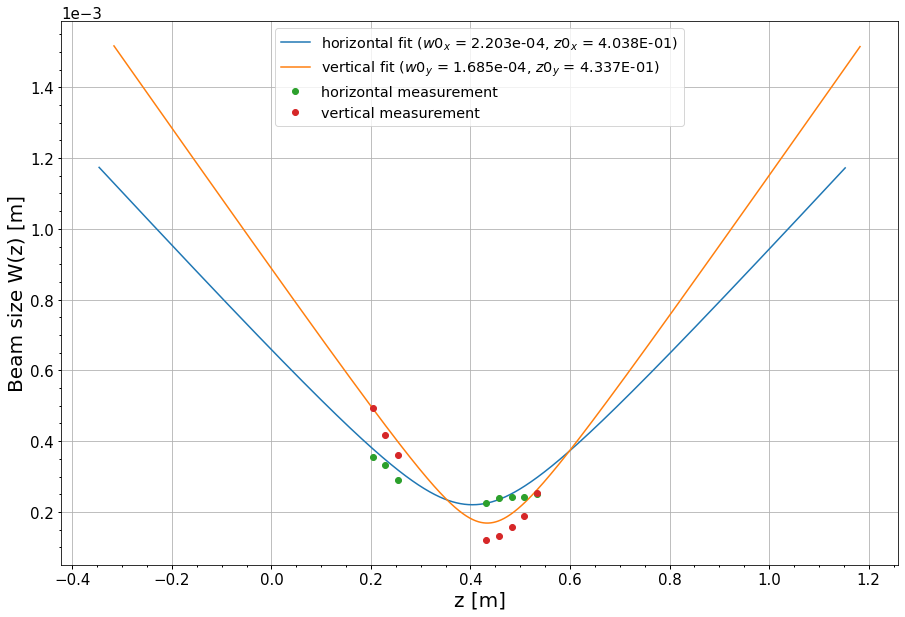

In [13]:
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.plot(new_z_horiz, w_beam(new_z_horiz,wavelen,res_x.x[0],res_x.x[1]), label='horizontal fit ($w0_x$ = {}, $z0_x$ = {})'.format("{:.3e}".format(res_x.x[0]),"{:.3E}".format(res_x.x[1])))
plt.plot(new_z_vert, w_beam(new_z_vert,wavelen,res_y.x[0],res_y.x[1]), label= 'vertical fit ($w0_y$ = {}, $z0_y$ = {})'.format("{:.3e}".format(res_y.x[0]),"{:.3E}".format(res_y.x[1])))
plt.plot(z_met,rad_x,'o', label='horizontal measurement')
plt.plot(z_met,rad_y,'o', label='vertical measurement')
plt.legend(fontsize='x-large')
plt.ylabel('Beam size W(z) [m]',fontsize=20)
plt.xlabel('z [m]',fontsize=20)
#plt.grid('True', which='both')
plt.grid('True')
ax.tick_params(which='both', width=1)
#ax.tick_params(which='minor', length=2)
ax.tick_params(labelsize=15)
ax.ticklabel_format(axis='y',style='sci', scilimits=(0,1e-6))
ax.yaxis.offsetText.set_fontsize(15)
plt.savefig(folder + fname+'_results.png',dpi=300,bbox_inches='tight')
